In [1]:
from google.colab import files
uploaded = files.upload()

Saving anuka.zip to anuka.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['anuka.zip']), 'r')
data.extractall()

In [4]:
import os
!mkdir dataset_anuka

mkdir: cannot create directory ‘dataset_anuka’: File exists


In [7]:
dataset_anuka_dir = '/content/dataset_anuka'

In [8]:
#Split data
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import splitfolders

splitfolders.ratio('/content/anuka', output='/content/dataset_anuka',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 2400 files [00:00, 5051.48 files/s]


In [10]:
import keras
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K

from keras import optimizers

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=[100, 100, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(64, 3, activation="relu", padding="same"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),    
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    #keras.layers.Dense(2, activation="softmax")
    keras.layers.Dense(2, activation="sigmoid")    
])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 12, 12, 128)     

In [49]:
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])
#model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#opt = SGD(learning_rate=0.01, momentum=0.9)
#model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


In [51]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255)
train_it = datagen.flow_from_directory('/content/dataset_anuka/train', batch_size=64, target_size=(100, 100))
validation_it = datagen.flow_from_directory('/content/dataset_anuka/val', batch_size=64, target_size=(100, 100))
test_it = datagen.flow_from_directory('/content/dataset_anuka/test', batch_size=64, target_size=(100, 100))
# fit model
history = model.fit(
      train_it, 
      steps_per_epoch=len(train_it),
      validation_data=validation_it, 
      validation_steps=len(validation_it), 
      epochs=5, 
      verbose=1)

Found 1920 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
Epoch 1/5
30/30 [==============================] - 37s 1s/step - loss: 0.5176 - accuracy: 0.7323 - val_loss: 0.3685 - val_accuracy: 0.8333
Epoch 2/5
30/30 [==============================] - 37s 1s/step - loss: 0.3734 - accuracy: 0.8542 - val_loss: 0.3676 - val_accuracy: 0.8458
Epoch 3/5
30/30 [==============================] - 36s 1s/step - loss: 0.3254 - accuracy: 0.8667 - val_loss: 0.3190 - val_accuracy: 0.8792
Epoch 4/5
30/30 [==============================] - 36s 1s/step - loss: 0.2979 - accuracy: 0.8833 - val_loss: 0.2910 - val_accuracy: 0.9083
Epoch 5/5
30/30 [==============================] - 35s 1s/step - loss: 0.2498 - accuracy: 0.9057 - val_loss: 0.2497 - val_accuracy: 0.9250


In [52]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [55]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

IMG_SIZE = (100,100)
x_test, y_test, labels = load_data('/content/dataset_anuka/test/', IMG_SIZE)
print(labels)

100%|██████████| 2/2 [00:00<00:00, 36.19it/s]

240 images loaded from /content/dataset_anuka/test/ directory.
{0: 'Tipo A_ Kunzea', 1: 'Tipo B_ Lepto'}


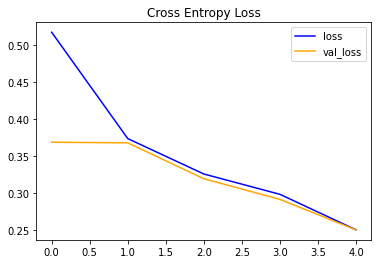

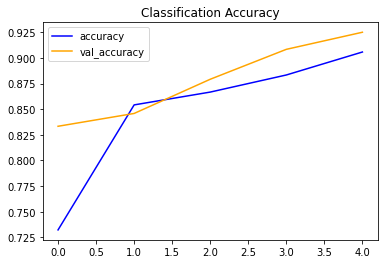

In [60]:
summarize_diagnostics(history)

In [62]:
classes = ['Tipo A_ Kunzea', 'Tipo B_ Lepto']

In [63]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)


                precision    recall  f1-score   support

Tipo A_ Kunzea       0.92      0.96      0.94       120
 Tipo B_ Lepto       0.96      0.92      0.94       120

      accuracy                           0.94       240
     macro avg       0.94      0.94      0.94       240
  weighted avg       0.94      0.94      0.94       240

[[115   5]
 [ 10 110]]


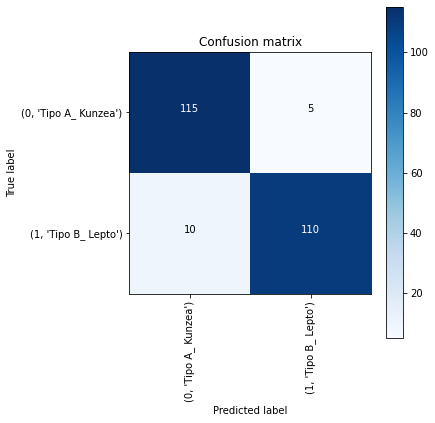

In [64]:
validateResults(model)

In [ ]:
!zip -r '/content/dataset_anuka.zip' '/content/dataset_anuka/'